Creates: '../OtherData/ActiveCasesVector.pickle' which maps dates to the number of active cases in each 250 region (date -> 250x1 vector)

'../OtherData/DailyODMatrix.pickle' which maps dates to the OD matrix for each day (date -> 250x250 matrix)

'../OtherData/DailyNumCasesImported.pickle' which maps dates to the product of the above incidence vector and OD matrix. This vector represents the approximate amount of cases imported into each destination region for each day (date-> 250x1 vector)

*Most recent run:* March 9 data.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import pickle
import datetime

In [2]:
file_suffix = "mar9"

### Read in all necessary files here

In [3]:
mapping = pd.read_csv("../OtherData/TAZdemography.csv")

In [4]:
mapping_dict = dict()
for _, row in mapping.iterrows():
    reg_250 = row["link to 250 model"]
    reg_sub = row["sub-district"]
    try:
        keep_in_dict = mapping_dict[reg_250]
        keep_in_dict.append(reg_sub)
        mapping_dict[reg_250] = keep_in_dict
    except:
        keep = list()
        keep.append(reg_sub)
        mapping_dict[reg_250] = keep

In [5]:
from collections import Counter

In [6]:
mapping_common = dict()

for k, v in mapping_dict.items():
    c = Counter(v)
    mapping_common[k] = c.most_common(1)[0][0]

In [7]:
mapping_common[2000023] = 11.0
mapping_common[2000045] = 31.0
mapping_common[2000048] = 32.0
mapping_common[2000050] = 22.0
mapping_common[2000063] = 31.0
mapping_common[2000064] = 32.0
mapping_common[2000083] = 31.0
mapping_common[2000084] = 24.0
mapping_common[2000088] = 31.0
mapping_common[2000090] = 32.0
mapping_common[2000092] = 24.0
mapping_common[2000093] = 23.0
mapping_common[2000146] = 42.0
mapping_common[2000147] = 42.0
mapping_common[2000152] = 44.0
mapping_common[2000153] = 44.0
mapping_common[2000161] = 42.0
mapping_common[2000177] = 51.0
mapping_common[2000205] = 51.0
mapping_common[2000220] = 61.0

In [8]:
results = pd.read_csv("../OtherData/results_mapping_feb14.csv")

In [9]:
od_df = pd.read_pickle("../OtherData/od_daily_ma_updated_jan2.pkl")

In [10]:
a250_to_16 = mapping_common #dict(zip(mapping["link to 250 model"], mapping["sub-district"]))

In [11]:
def dump_to_pickle(file, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(file, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved file")
    
dump_to_pickle(a250_to_16, "../OtherData/250_to_16_new.csv")

Saved file


### Code to organize trips and other mobility features

In [12]:
results.head()

,250_regions,date,accumulated_cases,accumulated_recoveries,accumulated_tested,active_cases,weighted_mean_poverty,population,median age
0,2000001.0,2020-05-02,24.0,14.0,547.0,10.0,2.0,45047.0,21.0
1,2000001.0,2020-05-03,24.0,14.0,556.0,10.0,2.0,45047.0,21.0
2,2000001.0,2020-05-04,24.0,15.0,565.0,9.0,2.0,45047.0,21.0
3,2000001.0,2020-05-05,24.0,15.0,580.0,9.0,2.0,45047.0,21.0
4,2000001.0,2020-05-06,24.0,15.0,589.0,9.0,2.0,45047.0,21.0


In [13]:
results = results.replace({"250_regions": a250_to_16})

In [14]:
results2 = results.groupby(['date', '250_regions']).sum()[["accumulated_cases", "accumulated_recoveries", "accumulated_tested", "active_cases", "population"]]

In [15]:
results2["median age"] = results.groupby(['date', '250_regions']).mean()[["median age"]]
results2["weighted_mean_poverty"] = results.groupby(['date', '250_regions']).mean()[["weighted_mean_poverty"]]

In [16]:
results2.head()

accumulated_cases  accumulated_recoveries  \
date       250_regions                                              
2020-04-06 11.0                      36.0                    15.0   
           43.0                      51.0                    15.0   
2020-04-07 11.0                      36.0                    16.0   
           43.0                      51.0                    17.0   
           71.0                     355.0                    96.0   

                        accumulated_tested  active_cases  population  \
date       250_regions                                                 
2020-04-06 11.0                      343.0          20.0     44896.0   
           43.0                      469.0          36.0     63694.0   
2020-04-07 11.0                      346.0          19.0     44896.0   
           43.0                      473.0          34.0     63694.0   
           71.0                     3386.0         259.0     44752.0   

                        median age  weighted_mean_poverty  
date       250_regions                                     
2020-04-06 11.0               25.0                    2.0  
           43.0               24.5                    7.0  
2020-04-07 11.0               25.0                    2.0  
           43.0               24.5                    7.0  
           71.0               19.0                    2.0

In [17]:
results = results2.reset_index()

In [18]:
results["active_cases"].replace(np.inf, 0, inplace=True)
results["active_cases"].replace(np.nan, 0, inplace=True)
results["prevalence"] = results["active_cases"] / results["population"]

results['date'] = pd.to_datetime(results["date"], dayfirst=True)
results1 = results.set_index(["date","250_regions"])

results1["new_cases"] = results1.groupby(by=["250_regions"])["accumulated_cases"].diff().fillna(0)
results1["new_tests"] = results1.groupby(by=["250_regions"])["accumulated_tested"].diff().fillna(0)
results1["new_cases"].replace(np.inf, 0, inplace=True)
results1["new_cases"].replace(np.nan, 0, inplace=True)
results1["new_tests"].replace(np.inf, 0, inplace=True)
results1["new_tests"].replace(np.nan, 0, inplace=True)

results1["positivity_rate"] = results1["new_cases"] / results1["new_tests"]
results1["positivity_rate"].replace(np.inf, 0, inplace=True)
results1["positivity_rate"].replace(np.nan, 0, inplace=True)

results1["positivity_rate"] = results1["positivity_rate"].clip(lower=0.0,upper=1.0)
results1["new_cases"] = results1["new_cases"].clip(lower=0.0)
results1["new_tests"] = results1["new_tests"].clip(lower=0.0)


In [19]:
results1.head()

accumulated_cases  accumulated_recoveries  \
date       250_regions                                              
2020-04-06 11.0                      36.0                    15.0   
           43.0                      51.0                    15.0   
2020-04-07 11.0                      36.0                    16.0   
           43.0                      51.0                    17.0   
           71.0                     355.0                    96.0   

                        accumulated_tested  active_cases  population  \
date       250_regions                                                 
2020-04-06 11.0                      343.0          20.0     44896.0   
           43.0                      469.0          36.0     63694.0   
2020-04-07 11.0                      346.0          19.0     44896.0   
           43.0                      473.0          34.0     63694.0   
           71.0                     3386.0         259.0     44752.0   

                        median age  weighted_mean_poverty  prevalence  \
date       250_regions                                                  
2020-04-06 11.0               25.0                    2.0    0.000445   
           43.0               24.5                    7.0    0.000565   
2020-04-07 11.0               25.0                    2.0    0.000423   
           43.0               24.5                    7.0    0.000534   
           71.0               19.0                    2.0    0.005787   

                        new_cases  new_tests  positivity_rate  
date       250_regions                                         
2020-04-06 11.0               0.0        0.0              0.0  
           43.0               0.0        0.0              0.0  
2020-04-07 11.0               0.0        3.0              0.0  
           43.0               0.0        4.0              0.0  
           71.0               0.0        0.0              0.0

In [20]:
dates = list(set(results["date"].values))

dates.sort()

In [21]:
dateToActiveCasesVector = dict()

In [22]:
subdistricts = list(set(results["250_regions"]))

subdistricts.sort()

print(subdistricts)

[11.0, 21.0, 22.0, 23.0, 24.0, 29.0, 31.0, 32.0, 41.0, 42.0, 43.0, 44.0, 51.0, 61.0, 62.0, 71.0]


In [23]:
results1.loc[('2020-04-06',43.0)]

accumulated_cases            51.000000
accumulated_recoveries       15.000000
accumulated_tested          469.000000
active_cases                 36.000000
population                63694.000000
median age                   24.500000
weighted_mean_poverty         7.000000
prevalence                    0.000565
new_cases                     0.000000
new_tests                     0.000000
positivity_rate               0.000000
Name: (2020-04-06 00:00:00, 43.0), dtype: float64

In [24]:
start = time.time()
for date in dates:
    active_cases_vector = np.zeros((72,))
    for region in subdistricts:
        try:
            active_cases_vector[int(region)] = results1.loc[(date,region)]["prevalence"]
        except:
            pass
    #print(date)
    #print(sum(active_cases_vector))
    dateToActiveCasesVector[date] = active_cases_vector
    
end = time.time()
print("Active cases vectors generated in %.3f s" % (end-start))

Active cases vectors generated in 1.058 s


In [25]:
dateToActiveCasesVector[np.datetime64('2020-12-01T00:00:00.000000000')]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00419019, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00079013, 0.00070536, 0.00253177, 0.00245665,
       0.        , 0.        , 0.        , 0.        , 0.00384592,
       0.        , 0.00183529, 0.00142662, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00130187, 0.00144043, 0.002862  , 0.00121403,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00114106, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00104511, 0.00136122, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00414915])

In [26]:
def string_date_to_datetime(string_date):
    return np.datetime64('%sT00:00:00.000000000' % (string_date))

def datetime_to_str(dt):
    return dt.strftime('%Y-%m-%d')
#dateToActiveCasesVector[string_date_to_datetime('2020-12-01')]

In [27]:
with open('../OtherData/ActiveCasesVector_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(dateToActiveCasesVector, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with open('../OtherData/ActiveCasesVector_%s.pkl' % (file_suffix), 'rb') as handle:
    b = pickle.load(handle)

# Create OD Matrix (if necessary)

In [29]:
od_df1 = od_df.set_index(["Date", "origin_250id", "dest_250id"])

In [30]:
od_df.head()

,Date,origin_250id,dest_250id,Trips,moving_7,moving_3
0,2020-02-01,2000001.0,2000001.0,3659.0,3659.0,3659.0
1,2020-02-01,2000001.0,2000002.0,1235.0,1235.0,1235.0
2,2020-02-01,2000001.0,2000003.0,692.0,692.0,692.0
3,2020-02-01,2000001.0,2000004.0,1594.0,1594.0,1594.0
4,2020-02-01,2000001.0,2000005.0,634.0,634.0,634.0


In [31]:
od_df = od_df.replace({"origin_250id": a250_to_16})
od_df = od_df.replace({"dest_250id": a250_to_16})
od_df['Date'] = pd.to_datetime(od_df["Date"], dayfirst=True)

In [32]:
od_dates = list(set(od_df["Date"].values))
od_dates.sort()

In [33]:
od_df1 = od_df.groupby(['Date', 'origin_250id', 'dest_250id']).sum()[["Trips"]]
od_df1 = od_df1.reset_index()

In [34]:
od_df1 = od_df1.set_index(["Date", "origin_250id", "dest_250id"])

In [35]:
od_df1.head()

Trips
Date       origin_250id dest_250id          
2020-02-01 11.0         11.0        447711.0
                        21.0            42.0
                        22.0           147.0
                        23.0           566.0
                        24.0           519.0

In [37]:
od_df1.loc[(string_date_to_datetime('2020-07-01'),11,11),"Trips"]

844421.0

In [38]:
dateToODMatrix = dict()
start = time.time()
for date in od_dates:
    od_matrix = np.zeros((72, 72))
    for origin_region in subdistricts:
        for dest_region in subdistricts:
            try: 
                od_matrix[int(origin_region)][int(dest_region)] = od_df1.loc[(date,origin_region,dest_region),"Trips"]
            except KeyError:
                pass
    dateToODMatrix[date] = od_matrix
    
end = time.time()
print("Daily OD Matrix generated in %.3f s" % (end-start))

Daily OD Matrix generated in 19.979 s


In [39]:
with open('../OtherData/DailyODMatrix_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(dateToODMatrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
with open('../OtherData/DailyODMatrix_%s.pkl' % (file_suffix), 'rb') as handle:
    c = pickle.load(handle)

In [41]:
c[string_date_to_datetime('2020-07-01')][11][11]

844421.0

In [42]:
# od data with dec as a repetition of nov
#plt.figure(figsize=(15,6))
#plt.plot(x, y)
#plt.show()

In [43]:
# get values from c (daily od matrix)

def c2(string_dt):
    return c[string_date_to_datetime(string_dt)]

In [44]:
c2('2020-07-01')[11][11]

844421.0

Dec 1 (Tuesday) - Dec 7 (Monday)
+ Model after November 24 (Tuesday) - November 30 (Monday)
+ Add noise both above and below November levels. The lockdown guidelines were the same.

December 8 (Tuesday) - December 26 (Saturday)
+ Similar to September 1 (Tuesday)  - September 14 (Monday) in terms of guidelines, but similar to July mobility 
+ Therefore, for this set of dates, average with July mobility levels
Thursday: July 1, 8, 15, 22, 29, September 3, 10
Friday: 2, 9, 16, 23, 30, September 4, 11
Saturday: 3, 10, 17, 24, 31, September 5, 12
Sunday: 4, 11, 18, 25, September 6, 13
Monday: 5, 12, 19, 26, September 7, 14
Tuesday: 6, 13, 20, 27, September 1, 8
Wednesday: 7, 14, 21, 28, September 2, 9
+ Add noise both above and below July levels

December 27 (Sunday) - January 7 (Thurs)
+ Model after September 20 (Sunday) (18-Fri) - September 24 (Thurs)
+ Add positive noise. While the guidelines were mostly the same, mobility  in December was higher because schools were open.


January 8 (Friday) - February 5 (Friday)
+ Model after September 25 (Friday) - October 11 (Sunday)

February 6 (Saturday) - Feb 20 (Saturday)
+ Model after October 18 (Sun) - October 24 (Sat)

Feb 21 (Sunday) onwards: similar to December (12/20) and thus July

In [45]:
def perturb_10pct(value):
    return np.array(value + np.random.normal(loc=0, scale=value*0.25)).clip(0)

def perturb_10pct_onlypos(value):
    return np.array(value + abs(np.random.normal(loc=0, scale=value*0.25))).clip(0)

In [46]:
# day of week, 
# starting with thursday = 0
# fri = 1
# sat = 2
# sun = 3
# mon = 4
# tues = 5
# weds = 6
july_baseline = dict()

july_baseline[0] = (c2('2020-07-01') + c2('2020-07-08') + c2('2020-07-15') + c2('2020-07-22') + c2('2020-07-29')) / 5
july_baseline[1] = (c2('2020-07-02') + c2('2020-07-09') + c2('2020-07-16') + c2('2020-07-23') + c2('2020-07-30')) / 5
july_baseline[2] = (c2('2020-07-03') + c2('2020-07-10') + c2('2020-07-17') + c2('2020-07-24') + c2('2020-07-31')) / 5
july_baseline[3] = (c2('2020-07-04') + c2('2020-07-11') + c2('2020-07-18') + c2('2020-07-25')) / 4
july_baseline[4] = (c2('2020-07-05') + c2('2020-07-12') + c2('2020-07-19') + c2('2020-07-26')) / 4
july_baseline[5] = (c2('2020-07-06') + c2('2020-07-13') + c2('2020-07-20') + c2('2020-07-27')) / 4
july_baseline[6] = (c2('2020-07-07') + c2('2020-07-14') + c2('2020-07-21') + c2('2020-07-28')) / 4

In [47]:
np.random.seed(0)

c[string_date_to_datetime('2020-12-01')] = perturb_10pct(c2('2020-11-24'))
c[string_date_to_datetime('2020-12-02')] = perturb_10pct(c2('2020-11-25'))
c[string_date_to_datetime('2020-12-03')] = perturb_10pct(c2('2020-11-26'))
c[string_date_to_datetime('2020-12-04')] = perturb_10pct(c2('2020-11-27'))
c[string_date_to_datetime('2020-12-05')] = perturb_10pct(c2('2020-11-28'))
c[string_date_to_datetime('2020-12-06')] = perturb_10pct(c2('2020-11-29'))
c[string_date_to_datetime('2020-12-07')] = perturb_10pct(c2('2020-11-30'))

date1 = datetime.date(2020, 12, 8)
date2 = datetime.date(2020, 12, 26)
day = datetime.timedelta(days=1)

day_of_week = 5
while date1 <= date2:
    c[string_date_to_datetime(datetime_to_str(date1))] = perturb_10pct(july_baseline[day_of_week])
    
    day_of_week = day_of_week + 1
    if day_of_week == 7:
        day_of_week = 0
    date1 = date1 + day
    
    
c[string_date_to_datetime('2020-12-27')] = perturb_10pct_onlypos(c2('2020-09-20'))
c[string_date_to_datetime('2020-12-28')] = perturb_10pct_onlypos(c2('2020-09-21'))
c[string_date_to_datetime('2020-12-29')] = perturb_10pct_onlypos(c2('2020-09-22'))
c[string_date_to_datetime('2020-12-30')] = perturb_10pct_onlypos(c2('2020-09-23'))
c[string_date_to_datetime('2020-12-31')] = perturb_10pct_onlypos(c2('2020-09-24'))
c[string_date_to_datetime('2021-01-01')] = perturb_10pct_onlypos(c2('2020-09-18'))
c[string_date_to_datetime('2021-01-02')] = perturb_10pct_onlypos(c2('2020-09-19'))
c[string_date_to_datetime('2021-01-03')] = perturb_10pct_onlypos(c2('2020-09-20'))
c[string_date_to_datetime('2021-01-04')] = perturb_10pct_onlypos(c2('2020-09-21'))
c[string_date_to_datetime('2021-01-05')] = perturb_10pct_onlypos(c2('2020-09-22'))
c[string_date_to_datetime('2021-01-06')] = perturb_10pct_onlypos(c2('2020-09-23'))
c[string_date_to_datetime('2021-01-07')] = perturb_10pct_onlypos(c2('2020-09-24'))

In [48]:

c[string_date_to_datetime('2021-01-08')] = perturb_10pct(c2('2020-09-25'))
c[string_date_to_datetime('2021-01-09')] = perturb_10pct(c2('2020-09-26'))
c[string_date_to_datetime('2021-01-10')] = perturb_10pct(c2('2020-09-27'))
c[string_date_to_datetime('2021-01-11')] = perturb_10pct(c2('2020-09-28'))
c[string_date_to_datetime('2021-01-12')] = perturb_10pct(c2('2020-09-29'))
c[string_date_to_datetime('2021-01-13')] = perturb_10pct(c2('2020-09-30'))
c[string_date_to_datetime('2021-01-14')] = perturb_10pct(c2('2020-10-01'))
c[string_date_to_datetime('2021-01-15')] = perturb_10pct(c2('2020-10-02'))
c[string_date_to_datetime('2021-01-16')] = perturb_10pct(c2('2020-10-03'))
c[string_date_to_datetime('2021-01-17')] = perturb_10pct(c2('2020-10-04'))
c[string_date_to_datetime('2021-01-18')] = perturb_10pct(c2('2020-10-05'))
c[string_date_to_datetime('2021-01-19')] = perturb_10pct(c2('2020-10-06'))
c[string_date_to_datetime('2021-01-20')] = perturb_10pct(c2('2020-10-07'))
c[string_date_to_datetime('2021-01-21')] = perturb_10pct(c2('2020-10-08'))
c[string_date_to_datetime('2021-01-22')] = perturb_10pct(c2('2020-09-25'))
c[string_date_to_datetime('2021-01-23')] = perturb_10pct(c2('2020-09-26'))
c[string_date_to_datetime('2021-01-24')] = perturb_10pct(c2('2020-09-27'))
c[string_date_to_datetime('2021-01-25')] = perturb_10pct(c2('2020-09-28'))
c[string_date_to_datetime('2021-01-26')] = perturb_10pct(c2('2020-09-29'))
c[string_date_to_datetime('2021-01-27')] = perturb_10pct(c2('2020-09-30'))
c[string_date_to_datetime('2021-01-28')] = perturb_10pct(c2('2020-10-01'))
c[string_date_to_datetime('2021-01-29')] = perturb_10pct(c2('2020-10-02'))
c[string_date_to_datetime('2021-01-30')] = perturb_10pct(c2('2020-10-03'))
c[string_date_to_datetime('2021-01-31')] = perturb_10pct(c2('2020-10-04'))
c[string_date_to_datetime('2021-02-01')] = perturb_10pct(c2('2020-10-05'))
c[string_date_to_datetime('2021-02-02')] = perturb_10pct(c2('2020-10-06'))
c[string_date_to_datetime('2021-02-03')] = perturb_10pct(c2('2020-10-07'))
c[string_date_to_datetime('2021-02-04')] = perturb_10pct(c2('2020-10-08'))
c[string_date_to_datetime('2021-02-05')] = perturb_10pct(c2('2020-10-09'))

c[string_date_to_datetime('2021-02-06')] = perturb_10pct(c2('2020-10-24'))
c[string_date_to_datetime('2021-02-07')] = perturb_10pct(c2('2020-10-18'))
c[string_date_to_datetime('2021-02-08')] = perturb_10pct(c2('2020-10-19'))
c[string_date_to_datetime('2021-02-09')] = perturb_10pct(c2('2020-10-20'))
c[string_date_to_datetime('2021-02-10')] = perturb_10pct(c2('2020-10-21'))
c[string_date_to_datetime('2021-02-11')] = perturb_10pct(c2('2020-10-22'))
c[string_date_to_datetime('2021-02-12')] = perturb_10pct(c2('2020-10-23'))
c[string_date_to_datetime('2021-02-13')] = perturb_10pct(c2('2020-10-24'))
c[string_date_to_datetime('2021-02-14')] = perturb_10pct(c2('2020-10-18'))
c[string_date_to_datetime('2021-02-15')] = perturb_10pct(c2('2020-10-19'))
c[string_date_to_datetime('2021-02-16')] = perturb_10pct(c2('2020-10-20'))
c[string_date_to_datetime('2021-02-17')] = perturb_10pct(c2('2020-10-21'))
c[string_date_to_datetime('2021-02-18')] = perturb_10pct(c2('2020-10-22'))
c[string_date_to_datetime('2021-02-19')] = perturb_10pct(c2('2020-10-23'))
c[string_date_to_datetime('2021-02-20')] = perturb_10pct(c2('2020-10-24'))

c[string_date_to_datetime('2021-02-21')] = perturb_10pct_onlypos(c2('2020-12-20'))
c[string_date_to_datetime('2021-02-22')] = perturb_10pct_onlypos(c2('2020-12-21'))
c[string_date_to_datetime('2021-02-23')] = perturb_10pct_onlypos(c2('2020-12-22'))
c[string_date_to_datetime('2021-02-24')] = perturb_10pct_onlypos(c2('2020-12-23'))
c[string_date_to_datetime('2021-02-25')] = perturb_10pct_onlypos(c2('2020-12-24'))
c[string_date_to_datetime('2021-02-26')] = perturb_10pct_onlypos(c2('2020-12-25'))
c[string_date_to_datetime('2021-02-27')] = perturb_10pct_onlypos(c2('2020-12-26'))

In [49]:
with open('../OtherData/DailyODMatrixWithFakeDecember_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(c, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
x = list(c.keys())
y = [c[i][11][21] for i in x]

In [51]:
c2('2020-07-01')[11][11]

844421.0

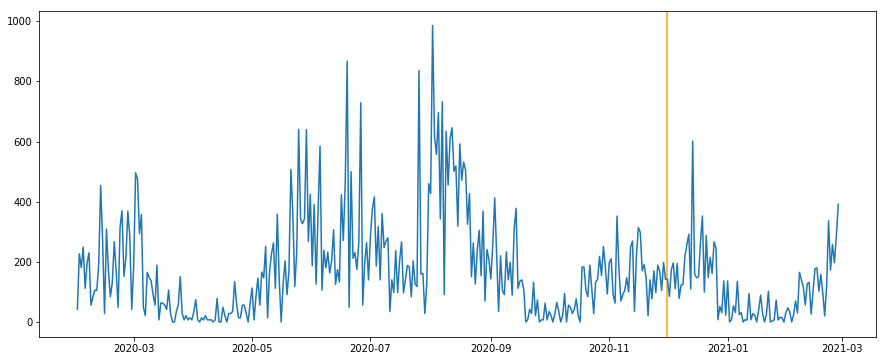

In [52]:
plt.figure(figsize=(15,6))
plt.axvline(x[-89], color='orange')
plt.plot(x, y)
plt.show()

# Create Excess OD Matrix

In [53]:
# day of week, 
# starting with saturday = 0
# sunday = 1
# monday = 2
# tuesday = 3
# weds = 4
# thurs = 5
# fri = 6

day_to_od_baseline = dict()

day_to_od_baseline[0] = (c2('2020-02-01') + c2('2020-02-08') + c2('2020-02-15') + c2('2020-02-22')) / 4
day_to_od_baseline[1] = (c2('2020-02-02') + c2('2020-02-09') + c2('2020-02-16') + c2('2020-02-23')) / 4
day_to_od_baseline[2] = (c2('2020-02-03') + c2('2020-02-10') + c2('2020-02-17') + c2('2020-02-24')) / 4
day_to_od_baseline[3] = (c2('2020-02-04') + c2('2020-02-11') + c2('2020-02-18') + c2('2020-02-25')) / 4
day_to_od_baseline[4] = (c2('2020-02-05') + c2('2020-02-12') + c2('2020-02-19') + c2('2020-02-26')) / 4
day_to_od_baseline[5] = (c2('2020-02-06') + c2('2020-02-13') + c2('2020-02-20') + c2('2020-02-27')) / 4
day_to_od_baseline[6] = (c2('2020-02-07') + c2('2020-02-14') + c2('2020-02-21') + c2('2020-02-28')) / 4

In [54]:
date1 = datetime.date(2020, 2, 29)
date2 = datetime.date(2021, 2, 27)
day = datetime.timedelta(days=1)

excess_od_matrix = dict()

day_of_week = 0

while date1 <= date2:
    
    excess_od_matrix[date1] = c2(date1) - day_to_od_baseline[day_of_week]
    
    date1 = date1 + day
    
    day_of_week = day_of_week + 1
    if day_of_week == 7:
        day_of_week = 0
        
with open('../OtherData/ExcessODMatrix_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(excess_od_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
c2('2020-07-01')[11][11]

844421.0

# Create mobility comparison to previous week

In [56]:
date1 = datetime.date(2020, 2, 29)
date2 = datetime.date(2021, 2, 27)
day = datetime.timedelta(days=1)
week = datetime.timedelta(days=7)

diffed_od_matrix = dict()

while date1 <= date2:
    
    diffed_od_matrix[date1] = c2(date1) - c2(date1 - week)
    
    date1 = date1 + day

with open('../OtherData/DiffedODMatrix_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(diffed_od_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
c2('2020-07-01')[11][21]

288.0

# Create matrix of mobility comparisons

In [58]:
dates = excess_od_matrix.keys()

with open('../OtherData/DailyODMatrixWithFakeDecember_%s.pkl' % (file_suffix), 'rb') as handle:
    c = pickle.load(handle)

with open('../OtherData/ExcessODMatrix_%s.pkl' % (file_suffix), 'rb') as handle:
    excess_od_matrix = pickle.load(handle)
    
with open('../OtherData/DiffedODMatrix_%s.pkl' % (file_suffix), 'rb') as handle:
    diffed_od_matrix = pickle.load(handle)

In [59]:
dates = excess_od_matrix.keys()

In [60]:
day_to_exposed_outside_region = dict()
day_to_exposed_inside_region = dict()

day_to_exposed_outside_region_excess = dict()
day_to_exposed_inside_region_excess = dict()

day_to_exposed_outside_region_diff = dict()
day_to_exposed_inside_region_diff = dict()

for date in dates:
    try:
        incidence_vec = b[string_date_to_datetime(date)]
        od_matrix_today = c2(date)
        excess_od_matrix_today = excess_od_matrix[date]
        diffed_od_matrix_today = diffed_od_matrix[date]

        # Multiply the incidence vector by the OD matrix to get total cases today
        day_to_exposed_inside_region[date] = np.transpose(incidence_vec) @ od_matrix_today
        day_to_exposed_inside_region_excess[date] = np.transpose(incidence_vec) @ excess_od_matrix_today
        day_to_exposed_inside_region_diff[date] = np.transpose(incidence_vec) @ diffed_od_matrix_today

        # Remove internal cases from region A to region A
        np.fill_diagonal(od_matrix_today, 0)
        np.fill_diagonal(excess_od_matrix_today, 0)
        np.fill_diagonal(diffed_od_matrix_today, 0)

        # Compute external cases by multiplying the incidence vector by the OD matrix
        day_to_exposed_outside_region[date] = np.transpose(incidence_vec) @ od_matrix_today
        day_to_exposed_outside_region_excess[date] = np.transpose(incidence_vec) @ excess_od_matrix_today
        day_to_exposed_outside_region_diff[date] = np.transpose(incidence_vec) @ diffed_od_matrix_today

        # Subtract external cases from all cases to get internal cases
        day_to_exposed_inside_region[date] = day_to_exposed_inside_region[date] - day_to_exposed_outside_region[date]
        day_to_exposed_inside_region_excess[date] = day_to_exposed_inside_region_excess[date] - day_to_exposed_outside_region_excess[date]
        day_to_exposed_inside_region_diff[date] = day_to_exposed_inside_region_diff[date] - day_to_exposed_outside_region_diff[date]
    except:
        pass

In [61]:
day_to_exposed_outside_region[datetime.date(2020,7,1)]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        , 210.37385901,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  11.63922565,  32.29140223,  96.34177693,
       127.65644546,   0.        ,   0.        ,   0.        ,
         0.        ,  12.29963337,   0.        ,  61.25128299,
        89.12124285,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  95.82366154, 191.48142215,  84.08875087,
       157.2950059 ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        , 184.30125541,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  82.44221419,  44.56094894,   0.  

In [62]:
print(sum(day_to_exposed_outside_region[datetime.date(2020,7,1)]))
print(sum(day_to_exposed_inside_region[datetime.date(2020,7,1)]))

print(sum(day_to_exposed_outside_region_excess[datetime.date(2020,7,1)]))
print(sum(day_to_exposed_inside_region_excess[datetime.date(2020,7,1)]))
print(sum(day_to_exposed_outside_region_diff[datetime.date(2020,7,1)]))
print(sum(day_to_exposed_inside_region_diff[datetime.date(2020,7,1)]))

1664.5976951129653
5415.840436731729
-210.44700646913765
-718.7315641464969
-5.769480928371722
-12.105052033117655


In [63]:
with open('../OtherData/DailyNumCasesImportedOutside_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(day_to_exposed_outside_region, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../OtherData/DailyNumCasesImportedWithin_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(day_to_exposed_inside_region, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../OtherData/DailyNumCasesImportedOutsideExcess_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(day_to_exposed_outside_region_excess, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../OtherData/DailyNumCasesImportedWithinExcess_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(day_to_exposed_inside_region_excess, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../OtherData/DailyNumCasesImportedOutsideDiff_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(day_to_exposed_outside_region_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../OtherData/DailyNumCasesImportedWithinDiff_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(day_to_exposed_inside_region_diff, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
start = time.time()
df = pd.DataFrame(columns=('Date', 'Region', 'Imported Cases', 'Internal Movement',
                           'Excess Imported Cases', 'Excess Internal Movement',
                           'Diff Imported Cases', 'Diff Internal Movement', 'Prevalence'))
index = 0

for date in day_to_exposed_inside_region_excess.keys():
    for region in subdistricts:
        df.loc[index] = [date, region,
                         day_to_exposed_outside_region[date][int(region)],
                         day_to_exposed_inside_region[date][int(region)],
                         day_to_exposed_outside_region_excess[date][int(region)],
                         day_to_exposed_inside_region_excess[date][int(region)],
                         day_to_exposed_outside_region_diff[date][int(region)],
                         day_to_exposed_inside_region_diff[date][int(region)],
                         b[string_date_to_datetime(date)][int(region)]]
        index = index + 1
end = time.time()
print("Time took = %.3f" % (end - start))

Time took = 6.995


In [65]:
df.tail()

,Date,Region,Imported Cases,Internal Movement,Excess Imported Cases,Excess Internal Movement,Diff Imported Cases,Diff Internal Movement,Prevalence
5035,2021-02-14,44.0,1163.158182,1766.979807,-325.700570,-833.935407,230.513896,227.286095,0.006701
5036,2021-02-14,51.0,1544.491578,1462.055723,-980.854550,-2203.170386,-41.032672,-600.000956,0.004844
5037,2021-02-14,61.0,502.824175,2745.084490,-193.667513,-662.255199,50.243184,842.894234,0.005860
5038,2021-02-14,62.0,426.142363,3239.311985,-194.564144,-856.281376,35.996424,-246.099231,0.003033
5039,2021-02-14,71.0,1291.765686,2826.707049,-652.604218,14.685800,-447.182980,308.189703,0.015703


In [66]:
# Excess mobility compared to February (averaged)

with open('../OtherData/ExcessAndDiffedMobility_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot some of the mobility data (imported cases and incidence)

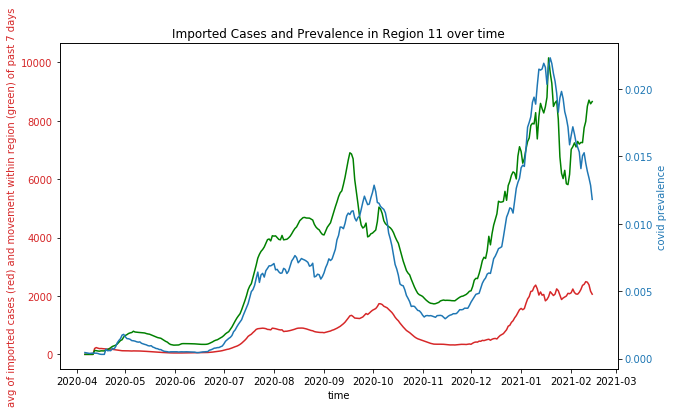

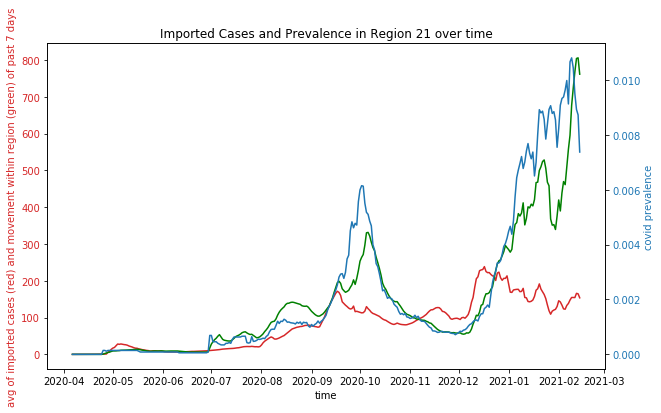

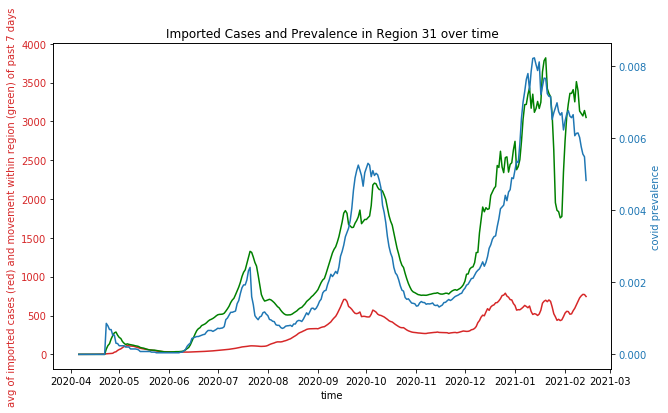

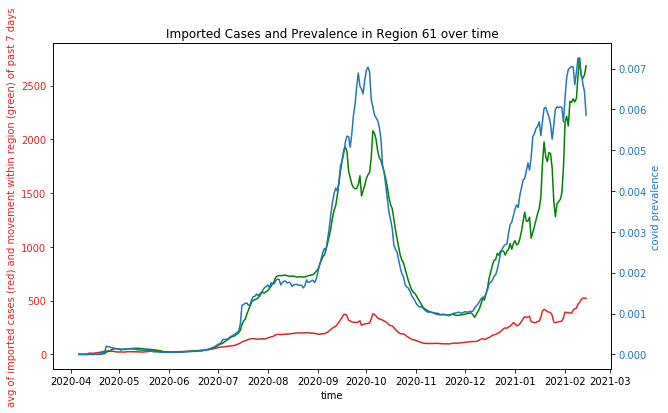

In [67]:
x_axis = list(day_to_exposed_outside_region.keys())

regions = [11, 21, 31, 61]

for region in regions:
    first_items = [d[int(region)] for d in day_to_exposed_outside_region.values()]
    imported_cases_moving_avg = pd.Series(first_items).rolling(7).mean().fillna(0)

    within_region_items = [d[int(region)] for d in day_to_exposed_inside_region.values()]
    internal_movement_moving_avg = pd.Series(within_region_items).rolling(7).mean().fillna(0)

    prevalence_items = [d[int(region)] for d in b.values()]
    prevalence_moving_avg = pd.Series(prevalence_items).rolling(7).mean().fillna(0)

    # expect a 7-14 day lag between imported cases and incidence in region 2000001

    fig, ax = plt.subplots(figsize=(10,6))
    #ax.plot(x_axis, eval_results['validation_1']['rmse'], label='Validation RMSE')
    color = 'tab:red'
    ax.set_xlabel('time')
    ax.set_ylabel('avg of imported cases (red) and movement within region (green) of past 7 days', color=color)
    #ax.plot(x_axis, first_items, color='salmon')
    ax.plot(x_axis, imported_cases_moving_avg, color=color)
    ax.plot(x_axis, internal_movement_moving_avg, color='green')
    ax.tick_params(axis='y', labelcolor=color)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('covid prevalence', color=color)  # we already handled the x-label with ax1
    ax2.plot(x_axis, prevalence_items, color=color)
    #ax2.plot(x_axis, incidence_moving_avg, color='purple')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Imported Cases and Prevalence in Region %d over time' % (region))
    plt.show()

In [68]:
df.tail()

,Date,Region,Imported Cases,Internal Movement,Excess Imported Cases,Excess Internal Movement,Diff Imported Cases,Diff Internal Movement,Prevalence
5035,2021-02-14,44.0,1163.158182,1766.979807,-325.700570,-833.935407,230.513896,227.286095,0.006701
5036,2021-02-14,51.0,1544.491578,1462.055723,-980.854550,-2203.170386,-41.032672,-600.000956,0.004844
5037,2021-02-14,61.0,502.824175,2745.084490,-193.667513,-662.255199,50.243184,842.894234,0.005860
5038,2021-02-14,62.0,426.142363,3239.311985,-194.564144,-856.281376,35.996424,-246.099231,0.003033
5039,2021-02-14,71.0,1291.765686,2826.707049,-652.604218,14.685800,-447.182980,308.189703,0.015703


# Combine the mobility df ("prevalence_df") with the health mapping results df ("results")

In [69]:
prevalence_df = df.rename(columns={"Date": "date", "Region": "250_regions"})
prevalence_df_1 = prevalence_df.set_index(["date","250_regions"])

In [70]:
combined = prevalence_df_1.join(results1, on=('date', '250_regions')).fillna(0)

In [71]:
def adjust_for_population(df, col_name):
    new_col_name = col_name + "_Adj100k"
    df[new_col_name] = df[col_name] * 100000 / df["population"]
    return df
    
combined = adjust_for_population(combined, 'Imported Cases')
combined = adjust_for_population(combined, 'Internal Movement')
combined = adjust_for_population(combined, 'Excess Imported Cases')
combined = adjust_for_population(combined, 'Excess Internal Movement')
combined = adjust_for_population(combined, 'Diff Imported Cases')
combined = adjust_for_population(combined, 'Diff Internal Movement')
combined = adjust_for_population(combined, 'active_cases')
combined = adjust_for_population(combined, 'new_cases')
combined = adjust_for_population(combined, 'new_tests')

In [72]:
combined2 = combined.dropna()
combined2.reset_index(inplace=True)
combined2 = combined2.rename(columns={'250_regions': 'Region', 'date': 'Date'})
print(combined2.columns)

Index(['Date', 'Region', 'Imported Cases', 'Internal Movement',
       'Excess Imported Cases', 'Excess Internal Movement',
       'Diff Imported Cases', 'Diff Internal Movement', 'Prevalence',
       'accumulated_cases', 'accumulated_recoveries', 'accumulated_tested',
       'active_cases', 'population', 'median age', 'weighted_mean_poverty',
       'prevalence', 'new_cases', 'new_tests', 'positivity_rate',
       'Imported Cases_Adj100k', 'Internal Movement_Adj100k',
       'Excess Imported Cases_Adj100k', 'Excess Internal Movement_Adj100k',
       'Diff Imported Cases_Adj100k', 'Diff Internal Movement_Adj100k',
       'active_cases_Adj100k', 'new_cases_Adj100k', 'new_tests_Adj100k'],
      dtype='object')


In [77]:
# Computes the moving average (including the most recent day)
combined2['Active_Cases_7_Adj100k'] = combined2.groupby(['Region'])['active_cases_Adj100k'].transform(lambda x: x.rolling(7, 1).mean())
combined2['New_Cases_7_Adj100k'] = combined2.groupby(['Region'])['new_cases_Adj100k'].transform(lambda x: x.rolling(7, 1).mean())
combined2['New_Tests_7_Adj100k'] = combined2.groupby(['Region'])['new_tests_Adj100k'].transform(lambda x: x.rolling(7, 1).mean())
combined2['Positivity_Rate_7'] = combined2.groupby(['Region'])['positivity_rate'].transform(lambda x: x.rolling(7, 1).mean())# Computes the moving average (including the most recent day)

combined2['Excess Imported_Cases_7_Adj100k'] = combined2.groupby(['Region'])['Excess Imported Cases_Adj100k'].transform(lambda x: x.rolling(7, 1).mean())
combined2['Diff Imported_Cases_7_Adj100k'] = combined2.groupby(['Region'])['Diff Imported Cases_Adj100k'].transform(lambda x: x.rolling(7, 1).mean())
combined2['Excess Internal_Movement_7_Adj100k'] = combined2.groupby(['Region'])['Excess Internal Movement_Adj100k'].transform(lambda x: x.rolling(7, 1).mean())
combined2['Diff Internal_Movement_7_Adj100k'] = combined2.groupby(['Region'])['Diff Internal Movement_Adj100k'].transform(lambda x: x.rolling(7, 1).mean())
combined2['Internal_Movement_7_Adj100k'] = combined2.groupby(['Region'])['Internal Movement_Adj100k'].transform(lambda x: x.rolling(7, 1).mean())

combined2["Pressure_7_Adj100k"] = combined2.groupby(['Region'])["Imported Cases_Adj100k"].transform(lambda x: x.rolling(7, 1).sum())
#combined2["Pressure_8_Adj100k"] = combined2.groupby(['Region'])["Imported Cases_Adj100k"].transform(lambda x: x.rolling(8, 1).sum())
combined2["Excess Pressure_7_Adj100k"] = combined2.groupby(['Region'])["Excess Imported Cases_Adj100k"].transform(lambda x: x.rolling(7, 1).sum())
#combined2["Excess Pressure_8_Adj100k"] = combined2.groupby(['Region'])["Excess Imported Cases_Adj100k"].transform(lambda x: x.rolling(8, 1).sum())
combined2["Diff Pressure_7_Adj100k"] = combined2.groupby(['Region'])["Diff Imported Cases_Adj100k"].transform(lambda x: x.rolling(7, 1).sum())
#combined2["Diff Pressure_8_Adj100k"] = combined2.groupby(['Region'])["Diff Imported Cases_Adj100k"].transform(lambda x: x.rolling(8, 1).sum())

In [78]:
for i in range(6):
    label = "New_Cases_7_Adj100k_" + str(i + 1) + "dayago"
    combined2[label] = combined2.groupby(['Region'])['New_Cases_7_Adj100k'].shift(i+1).fillna(0)
    label = "New_Tests_7_Adj100k_" + str(i + 1) + "dayago"
    combined2[label] = combined2.groupby(['Region'])['New_Tests_7_Adj100k'].shift(i+1).fillna(0)
    label = "Positivity_Rate_7_" + str(i + 1) + "dayago"
    combined2[label] = combined2.groupby(['Region'])['Positivity_Rate_7'].shift(i+1).fillna(0)
    label = "Active_Cases_7_Adj100k_7_" + str(i + 1) + "dayago"
    combined2[label] = combined2.groupby(['Region'])['Active_Cases_7_Adj100k'].shift(i+1).fillna(0)
for i in range(1):
    label = "Internal_Movement_7_Adj100k_" + str(i + 1) + "dayago"
    combined2[label] = combined2.groupby(['Region'])['Internal_Movement_7_Adj100k'].shift(i+1).fillna(0)
    label = "Excess Internal_Movement_7_Adj100k_" + str(i + 1) + "dayago"
    combined2[label] = combined2.groupby(['Region'])['Excess Internal_Movement_7_Adj100k'].shift(i+1).fillna(0)
    label = "Diff Internal_Movement_7_Adj100k_" + str(i + 1) + "dayago"
    combined2[label] = combined2.groupby(['Region'])['Diff Internal_Movement_7_Adj100k'].shift(i+1).fillna(0)
    label = "Pressure_7_Adj100k_" + str(i + 1) + "dayago"
    combined2[label] = combined2.groupby(['Region'])['Pressure_7_Adj100k'].shift(i+1).fillna(0)
    label = "Excess Pressure_7_Adj100k_" + str(i + 1) + "dayago"
    combined2[label] = combined2.groupby(['Region'])['Excess Pressure_7_Adj100k'].shift(i+1).fillna(0)
    label = "Diff Pressure_7_Adj100k_" + str(i + 1) + "dayago"
    combined2[label] = combined2.groupby(['Region'])['Diff Pressure_7_Adj100k'].shift(i+1).fillna(0)
combined2['NewCases_7_Adj100k_next7days'] = combined2.groupby(['Region'])['New_Cases_7_Adj100k'].shift(-7).fillna(0)
combined2['NewTests_7_Adj100k_next7days'] = combined2.groupby(['Region'])['New_Tests_7_Adj100k'].shift(-7).fillna(0)
combined2['Positivity_Rate_7_next7days'] = combined2.groupby(['Region'])['Positivity_Rate_7'].shift(-7).fillna(0)
combined2['Active_Cases_7_Adj100k_next7days'] = combined2.groupby(['Region'])['Active_Cases_7_Adj100k'].shift(-7).fillna(0)

In [87]:
combined2.where(combined2["Region"]==11).dropna()[["Date",'Imported Cases_Adj100k',"Pressure_7_Adj100k", "Pressure_7_Adj100k_1dayago"]].head(10)

,Date,Imported Cases_Adj100k,Pressure_7_Adj100k,Pressure_7_Adj100k_1dayago
0,2020-04-06,8.735610,8.735610,0.000000
2,2020-04-07,755.331243,764.066853,8.735610
5,2020-04-08,542.581815,1306.648668,764.066853
9,2020-04-09,407.745610,1714.394278,1306.648668
13,2020-04-10,483.867867,2198.262144,1714.394278
17,2020-04-11,399.363168,2597.625312,2198.262144
21,2020-04-12,545.981526,3143.606838,2597.625312
25,2020-04-13,491.061589,3625.932817,3143.606838
29,2020-04-14,445.264479,3315.866053,3625.932817
33,2020-04-15,312.335864,3085.620102,3315.866053


In [79]:
with open('../OtherData/CombinedDFAdjPopulationExcessMobility_%s.pkl' % (file_suffix), 'wb') as handle:
    pickle.dump(combined2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [80]:
combined2.head()

,Date,Region,Imported Cases,Internal Movement,Excess Imported Cases,Excess Internal Movement,Diff Imported Cases,Diff Internal Movement,Prevalence,accumulated_cases,...,Diff Internal_Movement_7_Adj100k_6dayago,NewCases_7_Adj100k_next7days,NewTests_7_Adj100k_next7days,Positivity_Rate_7_next7days,Active_Cases_7_Adj100k_next7days,Internal_Movement_7_Adj100k,Internal_Movement_7_Adj100k_1dayago,Pressure_7_Adj100k_1dayago,Excess Pressure_7_Adj100k_1dayago,Diff Pressure_7_Adj100k_1dayago
0,2020-04-06,11.0,3.921939,212.960175,-3.931265,-226.041407,1.078971,37.191287,0.000445,36.0,...,0.0,0.636391,8.909480,0.040816,40.092659,474.341087,0.000000,0.000000,0.000000,0.000000
1,2020-04-06,43.0,2.662598,54.670330,-3.809694,-53.559707,0.265948,11.647125,0.000565,51.0,...,0.0,0.224287,8.074320,0.023810,45.305905,85.832779,0.000000,0.000000,0.000000,0.000000
2,2020-04-07,11.0,339.113515,202.206366,-306.583999,-203.395876,40.443814,38.810005,0.000423,36.0,...,0.0,0.636391,8.591284,0.040816,39.456267,462.364732,474.341087,8.735610,-8.756382,2.403268
3,2020-04-07,43.0,34.100335,52.911012,-29.197440,-48.437749,6.876160,11.665180,0.000534,51.0,...,0.0,0.224287,9.868613,0.023810,43.063038,84.451708,85.832779,4.180296,-5.981244,0.417540
4,2020-04-07,71.0,30.927116,799.524759,-26.389180,-201.275965,4.001431,71.185645,0.005787,355.0,...,0.0,0.000000,122.899535,0.000000,474.041064,1786.567659,0.000000,0.000000,0.000000,0.000000
